In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, ZeroPadding2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from IPython.display import SVG
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Data normalization - normalize the data dimension that they are of approximately the same scale

In [3]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [4]:
print('Number of train data: ' + str(len(X_train)))
print('Number of test data: ' + str(len(X_test)))

Number of train data: 60000
Number of test data: 10000


### Split the data into train/validation/test

* train set - training the model
* validation set - tuning the hyperparameter and evaluate the models
* test set - testing the model after the model has gone through initial vetting by the validation set

In [5]:
# break training set into train and val sets.
#(X_train, X_val) = X_train[5000:], X_train[:5000]
#(y_train, y_val) = y_train[5000:], y_train[:5000]


# generate val set-- have issues with label sizes
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Fashion MNIST Train - rows: ', X_train.shape[0], ' columns: ', X_train.shape[1:4])
print('Fashion MNIST Validation - rows: ', X_val.shape[0], ' columns: ', X_val.shape[1:4])
print('Fashion MNIST Test - rows: ', X_test.shape[0], ' columns: ', X_test.shape[1:4])

Fashion MNIST Train - rows:  48000  columns:  (28, 28)
Fashion MNIST Validation - rows:  12000  columns:  (28, 28)
Fashion MNIST Test - rows:  10000  columns:  (28, 28)


In [6]:
# reshape the input data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
 
# one-hot encode 
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# print training set shape
print('X_tain shape: ', X_train.shape, 'y_train shape: ', y_train.shape)

print (X_train.shape[0], 'train set')
print (X_val.shape[0], 'validation set')
print (X_test.shape[0], 'test set')

X_tain shape:  (48000, 28, 28, 1) y_train shape:  (48000, 10)
48000 train set
12000 validation set
10000 test set


### Model Architecture

* Sequential model API in Keras
* Conv2D - create a convolutional layer
* Pooling() - create a pooling layer
* Dropout () - apply dropout

In [7]:
model = Sequential()

# Must define the input shape in the first layer of the neural network
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

#model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3)) #0.5
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

2022-01-26 15:59:56.122791: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile the model

Configure the learning process with compile() beforing training the model.

* optimizer
* loss function
* metrics

In [8]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Train the model

In [9]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
result = model.fit(X_train,
                   y_train,
                   batch_size=64,
                   epochs=20,
                   validation_data=(X_val, y_val),
                   callbacks=[checkpointer])

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.7054
Epoch 00001: val_loss improved from inf to 0.48504, saving model to model.weights.best.hdf5
750/750 [==============================] - 62s 81ms/step - loss: 0.7756 - accuracy: 0.7054 - val_loss: 0.4850 - val_accuracy: 0.8204
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8075
Epoch 00002: val_loss improved from 0.48504 to 0.40229, saving model to model.weights.best.hdf5
750/750 [==============================] - 60s 79ms/step - loss: 0.5101 - accuracy: 0.8075 - val_loss: 0.4023 - val_accuracy: 0.8526
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8368
Epoch 00003: val_loss improved from 0.40229 to 0.36025, saving model to model.weights.best.hdf5
750/750 [==============================] - 60s 79ms/step - loss: 0.4420 - accuracy: 0.8368 - val_loss: 0.3603 - val_accuracy: 0.8692
Epoch 4/20
750/750 [=========

### Load model with the bwst validation accuracy

In [10]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

### Test accuracy

In [11]:
# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9118000268936157


In [12]:
result.history['accuracy']

[0.7054166793823242,
 0.8074791431427002,
 0.8367916941642761,
 0.8528125286102295,
 0.8620625138282776,
 0.8702916502952576,
 0.8763958215713501,
 0.8798750042915344,
 0.8839791417121887,
 0.887541651725769,
 0.8882083296775818,
 0.8913750052452087,
 0.8929791450500488,
 0.8946041464805603,
 0.8962708115577698,
 0.898062527179718,
 0.8973125219345093,
 0.8970416784286499,
 0.8996875286102295,
 0.9008333086967468]

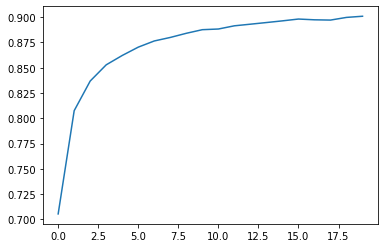

In [13]:
plt.plot(result.history['accuracy'])

In [14]:
result.history['val_accuracy']

[0.8204166889190674,
 0.8525833487510681,
 0.8692499995231628,
 0.8834166526794434,
 0.8900833129882812,
 0.8912500143051147,
 0.8957499861717224,
 0.8994166851043701,
 0.8995000123977661,
 0.9057499766349792,
 0.9011666774749756,
 0.9037500023841858,
 0.9056666493415833,
 0.9079166650772095,
 0.9129166603088379,
 0.9106666445732117,
 0.9102500081062317,
 0.909416675567627,
 0.9118333458900452,
 0.9171666502952576]

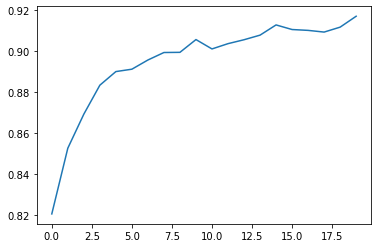

In [15]:
plt.plot(result.history['val_accuracy'])

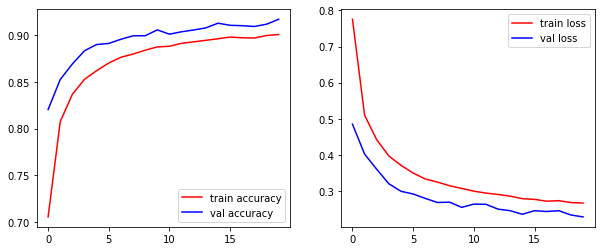

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(result.history['accuracy'], label='train accuracy', color='red')
plt.plot(result.history['val_accuracy'], label='val accuracy', color='blue')
plt.legend()

plt.subplot(1,2,2)
plt.plot(result.history['loss'], label='train loss', color='red')
plt.plot(result.history['val_loss'], label='val loss', color='blue')
plt.legend()

plt.savefig('Accuracy & Loss', dpi=150)
plt.show()

In [17]:
model.metrics_names

['loss', 'accuracy']

### Visualize prediction

Now let's visualize the prediction using the model you just trained. First we get the predictions with the model from the test data. Then we print out 15 images from the test data set, and set the titles with the prediction (and the groud truth label). If the prediction matches the true label, the title will be green; otherwise it's displayed in red.

In [18]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

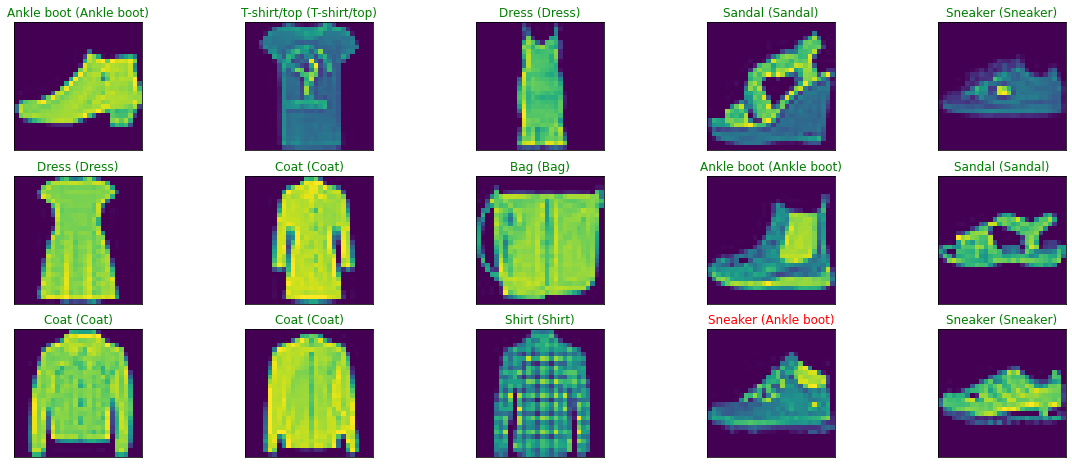

In [65]:
y_hat = model.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels true labels
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    plt.savefig('Output Sample', dpi=150)
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

### Confusion Matrix

In [20]:
import itertools

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

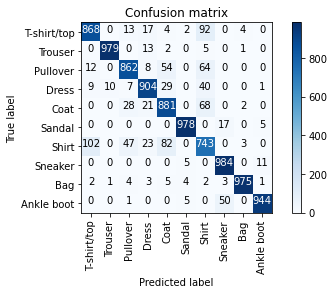

In [22]:
# predit the values from the validation dataset
y_pred = model.predict(X_test)
# convert prediction classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)
# convert validation observation to one hot vectors
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                                              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

* A large number of T-shirts/Tops are misclassified as Shirts
* also lots of Shirts are misclassified as Coats

#### Correctly Predicted Labels

In [67]:
correct = []
for i in range(len(y_test)):
    if (y_pred_classes[i] == y_true[i]):
        correct.append(i)
    if (len(correct) == 4):
        break

Text(0.5, 1.0, 'Predicted Label: Trouser\nAcutal Label: Trouser')

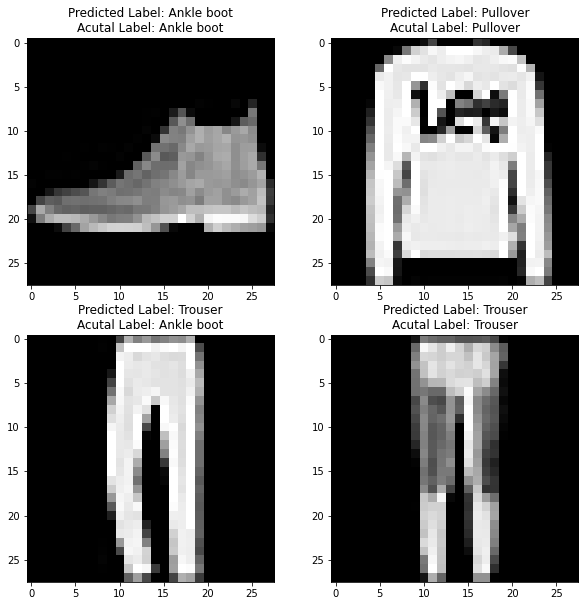

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.set_size_inches(10, 10)
ax[0, 0].imshow(X_test[correct[0]].reshape(28, 28), cmap='gray')
ax[0, 0].set_title('Predicted Label: ' + str(labels[y_pred_classes[correct[0]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[correct[0]]]))

ax[0, 1].imshow(X_test[correct[1]].reshape(28, 28), cmap='gray')
ax[0, 1].set_title('Predicted Label: ' + str(labels[y_pred_classes[correct[1]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[correct[1]]]))

ax[1, 0].imshow(X_test[correct[2]].reshape(28, 28), cmap='gray')
ax[1, 0].set_title('Predicted Label: ' + str(labels[y_pred_classes[correct[2]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[correct[0]]]))

ax[1, 1].imshow(X_test[correct[3]].reshape(28, 28), cmap='gray')
ax[1, 1].set_title('Predicted Label: ' + str(labels[y_pred_classes[correct[3]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[correct[3]]]))

#### Incorrectly Predicted Classes 

In [71]:
incorrect = []
for i in range(len(y_test)):
    if (not y_pred_classes[i] == y_true[i]):
        incorrect.append(i)
    if (len(incorrect) == 4):
        break

Text(0.5, 1.0, 'Predicted Label: Shirt\nAcutal Label: Dress')

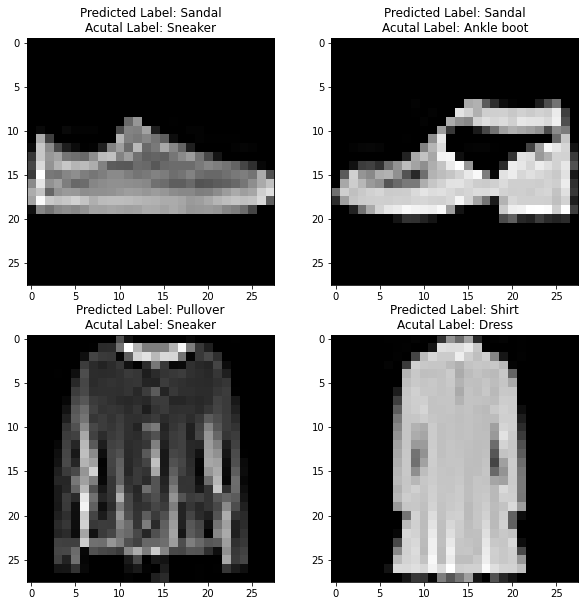

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.set_size_inches(10, 10)
ax[0, 0].imshow(X_test[incorrect[0]].reshape(28, 28), cmap='gray')
ax[0, 0].set_title('Predicted Label: ' + str(labels[y_pred_classes[incorrect[0]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[incorrect[0]]]))

ax[0, 1].imshow(X_test[incorrect[1]].reshape(28, 28), cmap='gray')
ax[0, 1].set_title('Predicted Label: ' + str(labels[y_pred_classes[incorrect[1]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[incorrect[1]]]))

ax[1, 0].imshow(X_test[incorrect[2]].reshape(28, 28), cmap='gray')
ax[1, 0].set_title('Predicted Label: ' + str(labels[y_pred_classes[incorrect[2]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[incorrect[0]]]))

ax[1, 1].imshow(X_test[incorrect[3]].reshape(28, 28), cmap='gray')
ax[1, 1].set_title('Predicted Label: ' + str(labels[y_pred_classes[incorrect[3]]])
                  + '\n' + 'Acutal Label: ' + 
                  str(labels[y_true[incorrect[3]]]))

### Classification Report

In [74]:
print(classification_report(y_true, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.87      0.87      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.90      0.86      0.88      1000
       Dress       0.91      0.90      0.91      1000
        Coat       0.83      0.88      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.73      0.74      0.74      1000
     Sneaker       0.93      0.98      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

